This notebook is to forecast how long a property will spend on the market, with properties spending fewer days being labelled as properties that are more in-demand.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the cleaned DataFrame
df = pd.read_parquet('../data/curated/model_data.parquet')

df.head(5)

,bedrooms,bathrooms,propertyTypes,carspaces,latitude,longitude,price,is_furnished,year,SA2_CODE21,...,date_numeric,median_income,distance_to_hospital,distance_to_supermarket,distance_to_park,distance_to_mall,distance_to_CBD,distance_to_school,distance_to_uni,crime
0,1.0,1.0,[apartmentUnitFlat],0.0,-37.815016,144.965968,380.0,0,2011,206041503,...,14,NaN,0.001411,0.002191,0.004031,0.000796,0.003437,0.005759,0.006994,1266.438330
1,2.0,1.0,[apartmentUnitFlat],1.0,-37.816257,144.953288,550.0,0,2011,206041505,...,16,NaN,0.003685,0.002027,0.002119,0.000581,0.013828,0.003552,0.013897,1192.420522
2,1.0,1.0,[apartmentUnitFlat],0.0,-37.821294,144.955768,370.0,0,2011,206041505,...,16,NaN,0.005240,0.003146,0.000254,0.005058,0.011588,0.008511,0.015817,1192.420522
3,2.0,1.0,[apartmentUnitFlat],1.0,-37.760855,144.961691,429.0,0,2011,206011495,...,30,NaN,0.001683,0.001678,0.001734,0.014051,0.057691,0.010984,0.035241,820.152825
4,2.0,1.0,[apartmentUnitFlat],1.0,-37.810074,144.985476,460.0,0,2011,206041119,...,44,NaN,0.000471,0.000370,0.000689,0.009837,0.020259,0.008693,0.020980,835.571731


We also want to pre-process the data one last time so that it is suitable for the model while also removing any outliers.

In [2]:
cleaned_df = df.copy()

cleaned_df.drop(columns=['propertyTypes'], inplace=True)
cleaned_df.drop(columns=['longitude'], inplace=True)
cleaned_df.drop(columns=['latitude'], inplace=True)
cleaned_df.drop(columns=['median_income'], inplace=True)


# Initial count of rows
initial_count = cleaned_df.shape[0]

# Define outlier thresholds
price_threshold = cleaned_df['price'].quantile(0.995)  # Example threshold for high prices
bedrooms_threshold = 6  # Example threshold for maximum bedrooms
bathrooms_threshold = 7  # Example threshold for maximum bathrooms
carspaces_threshold = 4  # Example threshold for maximum carspaces

# Remove outliers based on defined thresholds
filtered_df = cleaned_df[
    (cleaned_df['price'] <= price_threshold) &
    (cleaned_df['bedrooms'] <= bedrooms_threshold) &
    (cleaned_df['bathrooms'] <= bathrooms_threshold) &
    (cleaned_df['carspaces'] <= carspaces_threshold)
]

# Count of rows after filtering
filtered_count = filtered_df.shape[0]

# Print counts before and after
print(f"Initial number of rows: {initial_count}")
print(f"Number of rows after outlier removal: {filtered_count}")

filtered_df.head(5)

Initial number of rows: 120526
Number of rows after outlier removal: 119574


,bedrooms,bathrooms,carspaces,price,is_furnished,year,SA2_CODE21,days_on_market,population,distance_to_bus_stop,...,bed_bath_interaction,date_numeric,distance_to_hospital,distance_to_supermarket,distance_to_park,distance_to_mall,distance_to_CBD,distance_to_school,distance_to_uni,crime
0,1.0,1.0,0.0,380.0,0,2011,206041503,NaN,7939,0.003576,...,1.0,14,0.001411,0.002191,0.004031,0.000796,0.003437,0.005759,0.006994,1266.438330
1,2.0,1.0,1.0,550.0,0,2011,206041505,NaN,7475,0.001879,...,2.0,16,0.003685,0.002027,0.002119,0.000581,0.013828,0.003552,0.013897,1192.420522
2,1.0,1.0,0.0,370.0,0,2011,206041505,NaN,7475,0.002997,...,1.0,16,0.005240,0.003146,0.000254,0.005058,0.011588,0.008511,0.015817,1192.420522
3,2.0,1.0,1.0,429.0,0,2011,206011495,NaN,11981,0.000593,...,2.0,30,0.001683,0.001678,0.001734,0.014051,0.057691,0.010984,0.035241,820.152825
4,2.0,1.0,1.0,460.0,0,2011,206041119,NaN,5238,0.001944,...,2.0,44,0.000471,0.000370,0.000689,0.009837,0.020259,0.008693,0.020980,835.571731


In [3]:
days_threshold = filtered_df["days_on_market"].quantile(0.995)
# Filter the DataFrame to include only rows where days_on_market is >= 0 and <= days_threshold
filtered_df = filtered_df[(filtered_df["days_on_market"] >= 0) & (filtered_df["days_on_market"] <= days_threshold)]

In [5]:
filtered_df.count()

bedrooms                   53189
bathrooms                  53189
carspaces                  53189
price                      53189
is_furnished               53189
year                       53189
SA2_CODE21                 53189
days_on_market             53189
population                 53189
distance_to_bus_stop       53189
distance_to_train_stop     53189
distance_to_tram_stop      53189
bed_bath_interaction       53189
date_numeric               53189
distance_to_hospital       53189
distance_to_supermarket    53189
distance_to_park           53189
distance_to_mall           53189
distance_to_CBD            53189
distance_to_school         53189
distance_to_uni            53189
dtype: int64

We first want to train the model using data from 2011-2023 data and evaluate it on 2024 data.

In [4]:
# Define the target variable and features
target = 'days_on_market'
features = [col for col in filtered_df.columns if col != target]

# Split the data into train and test sets
train_data = filtered_df[filtered_df['year'].between(2011, 2023)]
test_data = filtered_df[filtered_df['year'] == 2024]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]


We perform hyperparameter tuning to see which hyperparameters result in a better model for the data.

In [21]:
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from collections import Counter

# Sample 20% of the training data for each round of grid search
sample_fraction = 0.2

# Define the parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 250],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}

# Store results from different random state runs
results = []
best_params_list = []

# Run multiple rounds of grid search with different random states for data sampling
for run in range(10):
    # Use different random states for each sampling round
    random_state_sample = np.random.randint(0, 1000)

    # Sample the training data
    X_train_sampled, _, y_train_sampled, _ = train_test_split(
        X_train, y_train, train_size=sample_fraction, random_state=random_state_sample
    )

    # Concatenate training and evaluation data to create a single dataset
    X_combined = pd.concat([X_train_sampled, X_test])
    y_combined = pd.concat([y_train_sampled, y_test])

    # Create a predefined split: -1 for train, 0 for test
    test_fold = [-1] * len(X_train_sampled) + [0] * len(X_test)
    ps = PredefinedSplit(test_fold)

    # Initialize the RandomForestRegressor model
    rf_reg = RandomForestRegressor(random_state=42)  # Random state here controls only reproducibility for the RF itself

    # Setup GridSearchCV with the predefined split
    grid_search = GridSearchCV(
        estimator=rf_reg, param_grid=param_grid,
        scoring='neg_root_mean_squared_error', cv=ps, n_jobs=-1, verbose=1
    )

    # Fit the model using the predefined train-test split
    grid_search.fit(X_combined, y_combined)

    # Store the results for this random state
    results.append({
        "random_state_sample": random_state_sample,
        "best_params": grid_search.best_params_,
        "best_score": -grid_search.best_score_  # Negative sign because `neg_root_mean_squared_error` is used
    })

    best_params_list.append(grid_search.best_params_)
    print(f"Run {run + 1}: Best parameters found: {grid_search.best_params_}")
    print(f"Run {run + 1}: Best RMSE score found: {-grid_search.best_score_}")

# Find the most common parameters across runs
most_common_params = Counter(tuple(sorted(p.items())) for p in best_params_list).most_common(1)
print("Most common hyperparameters across runs:", most_common_params)


Fitting 1 folds for each of 216 candidates, totalling 216 fits
Run 1: Best parameters found: {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Run 1: Best RMSE score found: 18.695928036106935
Fitting 1 folds for each of 216 candidates, totalling 216 fits
Run 2: Best parameters found: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Run 2: Best RMSE score found: 18.592524374515072
Fitting 1 folds for each of 216 candidates, totalling 216 fits
Run 3: Best parameters found: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Run 3: Best RMSE score found: 18.13178622997281
Fitting 1 folds for each of 216 candidates, totalling 216 fits
Run 4: Best parameters found: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_sample

/home/robertus/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run 7: Best parameters found: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250}
Run 7: Best RMSE score found: 17.95576746890281
Fitting 1 folds for each of 216 candidates, totalling 216 fits
Run 8: Best parameters found: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Run 8: Best RMSE score found: 18.6096561886426
Fitting 1 folds for each of 216 candidates, totalling 216 fits
Run 9: Best parameters found: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Run 9: Best RMSE score found: 18.56559507652347
Fitting 1 folds for each of 216 candidates, totalling 216 fits
Run 10: Best parameters found: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Run 10: Best RMSE score foun

We run 2 different models to compare 2 sets of hyperparameters to see which one is better and the hyperparameters from the better model are chosen.

In [5]:

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=250, bootstrap=False, max_depth=5, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and compute RMSE
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Root Mean Squared Error (RMSE) of Random Forest Regressor: {rmse:.2f}")

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, bootstrap=False, max_depth=5, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and compute RMSE
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Root Mean Squared Error (RMSE) of Random Forest Regressor: {rmse:.2f}")

Root Mean Squared Error (RMSE) of Random Forest Regressor: 18.15
Root Mean Squared Error (RMSE) of Random Forest Regressor: 18.15
Root Mean Squared Error (RMSE) of Random Forest Regressor: 18.15
Root Mean Squared Error (RMSE) of Random Forest Regressor: 18.16


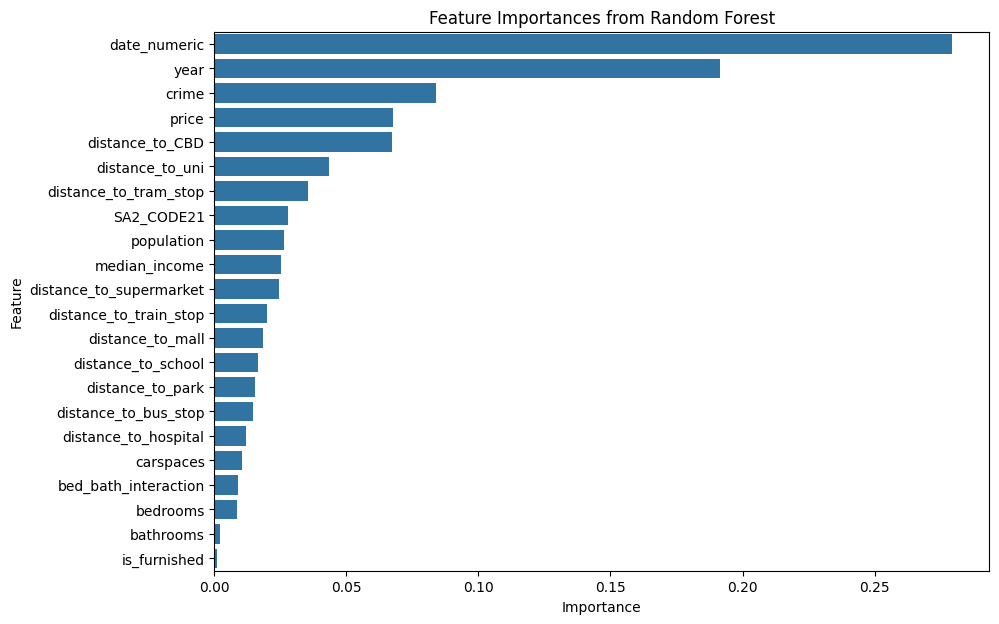

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


# Feature Importance from Random Forest
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()

Now that we have done initial modelling, we begin with forecasting by using the entire dataset as training data.

In [22]:
# Define the target variable and features
target = 'days_on_market'
features = [col for col in filtered_df.columns if col != target]

train_data = filtered_df[filtered_df['year'].between(2011, 2024)]

X_train = train_data[features]
y_train = train_data[target]

test_data = pd.read_csv('../data/curated/test_data_priced.csv')

In [29]:
rf_model = RandomForestRegressor(n_estimators=250, bootstrap=False, max_depth=5, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, random_state=42)
rf_model.fit(X_train, y_train)

test_data["price"] = test_data["predicted_target"]
test_data = test_data[X_train.columns]  # Ensure test_data has the same columns as X_train
test_data['predicted_target'] = rf_model.predict(test_data)

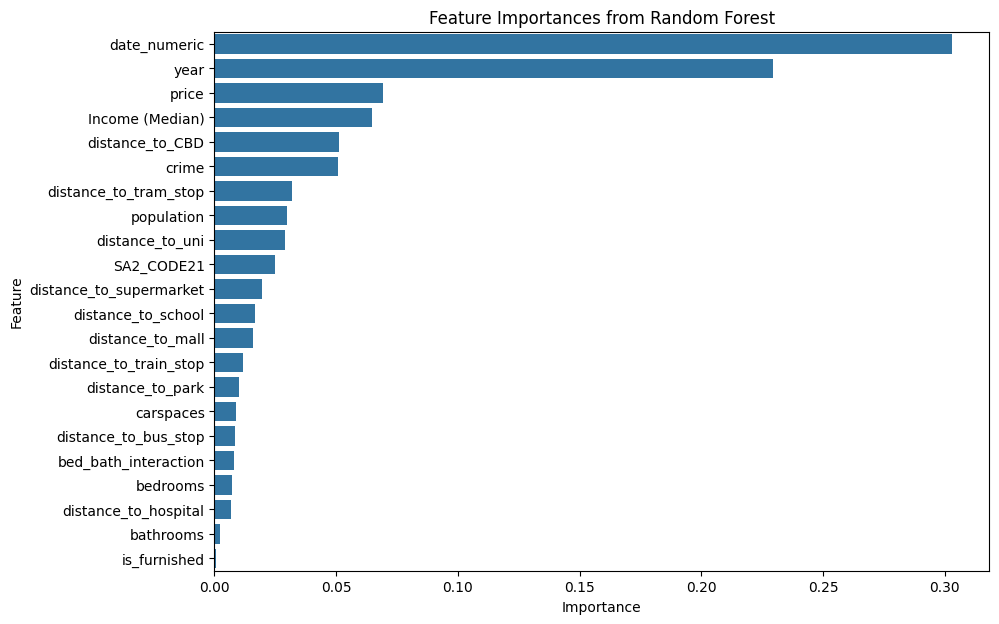

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


# Feature Importance from Random Forest
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()

From the predictions, highlight which SA2s spend the fewest days on the market on average, indicating those SA2s are more in-demand than others. Filter for only SA2s that have more than 50 listings in the training data to improve the accuracy of the results

In [32]:
import pandas as pd
from tabulate import tabulate

# Load population data (or suburb data)
population_df = pd.read_csv('../data/curated/forecasted_populations.csv')

# Ensure 'SA2_CODE21' is numeric in both dataframes
population_df['SA2_CODE21'] = pd.to_numeric(population_df['Code'], errors='coerce')
test_data['SA2_CODE21'] = pd.to_numeric(test_data['SA2_CODE21'], errors='coerce')

# Drop NaN values and duplicates in population data
population_df = population_df.dropna(subset=['SA2_CODE21']).drop_duplicates(subset='SA2_CODE21')

# Calculate mean `days_on_market` for 2023 and 2024 from training data
train_data['SA2_CODE21'] = pd.to_numeric(train_data['SA2_CODE21'], errors='coerce')
train_data = train_data.dropna(subset=['SA2_CODE21'])

# Filter data for 2023 and 2024
train_data_2023 = train_data[train_data['year'] == 2023]
train_data_2024 = train_data[train_data['year'] == 2024]

# Calculate mean `days_on_market` for each SA2 region in 2023 and 2024
avg_days_2023 = train_data_2023.groupby('SA2_CODE21')['days_on_market'].mean().reset_index()
avg_days_2024 = train_data_2024.groupby('SA2_CODE21')['days_on_market'].mean().reset_index()

# Rename columns for clarity
avg_days_2023.columns = ['SA2_CODE21', 'predicted_days_2023']
avg_days_2024.columns = ['SA2_CODE21', 'predicted_days_2024']

# Merge the 2023 and 2024 averages into a single DataFrame
avg_days_23_24 = avg_days_2023.merge(avg_days_2024, on='SA2_CODE21', how='outer')

# Create a pivot table for 2025, 2026, and 2027 predicted 'days_on_market'
pivot_days_on_market = test_data.pivot_table(
    index='SA2_CODE21',
    columns='year',
    values='predicted_target'  # Ensure 'predicted_target' corresponds to predicted 'days_on_market'
).reset_index()

# Rename the columns for clarity
pivot_days_on_market.columns.name = None  # Remove the column index name
pivot_days_on_market.columns = [
    'SA2_CODE21', 
    'predicted_days_2025', 
    'predicted_days_2026', 
    'predicted_days_2027'
]

# Merge the 2023 and 2024 data with the pivot table for 2025-2027
pivot_days_on_market = pivot_days_on_market.merge(avg_days_23_24, on='SA2_CODE21', how='left')

# Reorder the columns to maintain chronological order
pivot_days_on_market = pivot_days_on_market[
    ['SA2_CODE21', 'predicted_days_2023', 'predicted_days_2024', 
     'predicted_days_2025', 'predicted_days_2026', 'predicted_days_2027']
]

# Calculate the count of properties in the training data for each SA2
train_property_counts = train_data.groupby('SA2_CODE21').size().reset_index(name='property_count')
train_property_counts['SA2_CODE21'] = train_property_counts['SA2_CODE21'].astype(int)

# Merge the property count with `pivot_days_on_market` data
sa2_days_with_count = pivot_days_on_market.merge(train_property_counts, on='SA2_CODE21', how='left')

# Merge with suburb names from the population data
sa2_days_with_suburb = sa2_days_with_count.merge(
    population_df[['SA2_CODE21', 'Suburb']], 
    on='SA2_CODE21', 
    how='left'
)

# Remove rows where property counts are 50 or less
sa2_days_filtered = sa2_days_with_suburb[sa2_days_with_suburb['property_count'] > 50]

# Create a separate print for the lowest days on market in 2027, including 2023 and 2024 values
sa2_lowest_sorted = sa2_days_filtered.sort_values(by='predicted_days_2027', ascending=True)

print("\nSA2 districts with the lowest predicted days on market in 2027 (including property counts and values for 2023 and 2024):")
print(tabulate(sa2_lowest_days_2027, headers='keys', tablefmt='psql', showindex=False))

# Save the final filtered DataFrame to a CSV file
sa2_lowest_sorted.to_csv('../data/curated/sa2_days_filtered.csv', index=False)



SA2 districts with the lowest predicted days on market in 2027 (including property counts and values for 2023 and 2024):
+--------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-------------------------+--------------------------+------------------+-----------------------------------------------+
|   SA2_CODE21 |   predicted_days_2023 |   predicted_days_2024 |   predicted_days_2025 |   predicted_days_2026 |   predicted_days_2027 |   days_on_market_change |   percentage_change_days |   property_count | Suburb                                        |
|--------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-------------------------+--------------------------+------------------+-----------------------------------------------|
|    206051128 |              30.931   |               24.95   |               31.2011 |               31.2